In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cuda device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


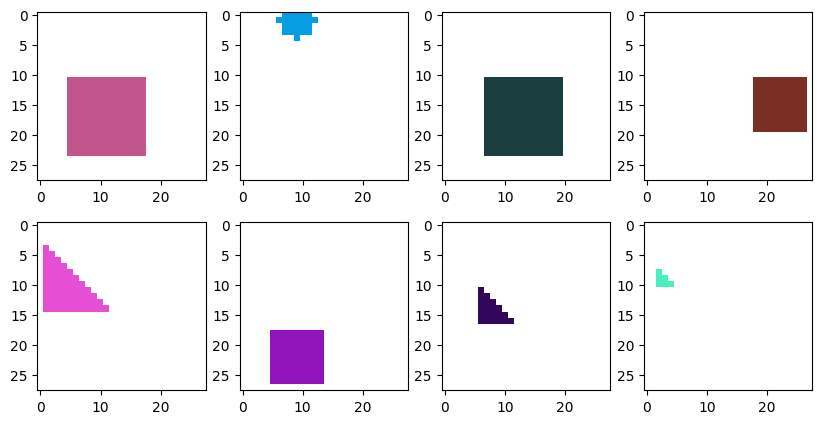

In [22]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=60000, image_size=(28, 28), random_color=True):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


class GeometricFiguresDatasetBlackWhite(GeometricFiguresDataset):
    def __init__(self, num_samples=60000, image_size=(28, 28)):
        super().__init__(num_samples, image_size, random_color=False)

    def choose_color(self):
        return np.array([0, 0, 0])  # Black color

    def __getitem__(self, idx):
        img, label =  super().__getitem__(idx)
        img = img[0]  # Take only one channel
        img = img/255.0  # Normalize
        return img, label




dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


----

In [23]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True, num_samples=20000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=256, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.unflatten = nn.Unflatten(1, [256, 1, 1])
        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(h_dim, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

torch.Size([128, 3, 28, 28])


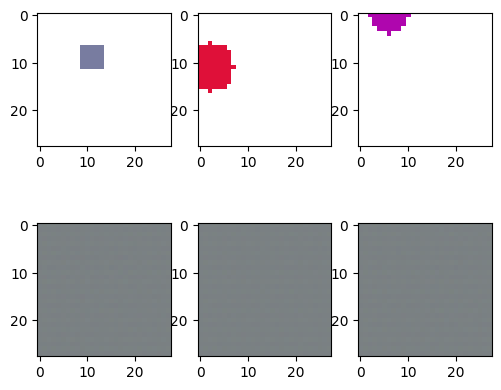

In [24]:
model = VAE(image_channels=3).to(device)



random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)[0]


print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [ ]:
# input = 15
# k = 4
# s = 2
# padding = 2

# output = (input - 1) * s - 2 * padding + (k-1) + 1
# output

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [27]:

epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    running_kl = 0.0
    running_recon = 0.0
    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)

        loss, recon, kld = loss_fn(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * images.size(0)
        running_kl += kld.item() * images.size(0)
        running_recon += recon.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.5f}; Recon: {running_recon / len(dataloader.dataset):.5f}; KL: {running_kl / len(dataloader.dataset):.5f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/50], Loss: 58550.90270; Recon: 58549.48787; KL: 1.41493
Epoch [2/50], Loss: 28571.48933; Recon: 28567.55242; KL: 3.93697
Epoch [3/50], Loss: 24647.83460; Recon: 24642.96093; KL: 4.87375
Epoch [4/50], Loss: 23973.37343; Recon: 23967.84318; KL: 5.53034
Epoch [5/50], Loss: 23527.55550; Recon: 23522.03924; KL: 5.51624
Epoch [6/50], Loss: 23324.26987; Recon: 23318.57812; KL: 5.69177
Epoch [7/50], Loss: 23002.08829; Recon: 22996.22733; KL: 5.86087
Epoch [8/50], Loss: 23087.97816; Recon: 23081.85444; KL: 6.12365
Epoch [9/50], Loss: 22776.74783; Recon: 22770.55039; KL: 6.19744
Epoch [10/50], Loss: 22689.03811; Recon: 22682.50554; KL: 6.53247
Epoch [11/50], Loss: 22926.13089; Recon: 22920.46710; KL: 5.66369
Epoch [12/50], Loss: 22402.14011; Recon: 22395.74691; KL: 6.39320
Epoch [13/50], Loss: 22241.57297; Recon: 22234.83916; KL: 6.73382
Epoch [14/50], Loss: 22281.87983; Recon: 22275.24288; KL: 6.63698
Epoch [15/50], Loss: 22182.29685; Recon: 22175.52458; KL: 6.77236
Epoch [16/50], Loss

torch.Size([128, 3, 28, 28]) torch.Size([128, 3, 28, 28])


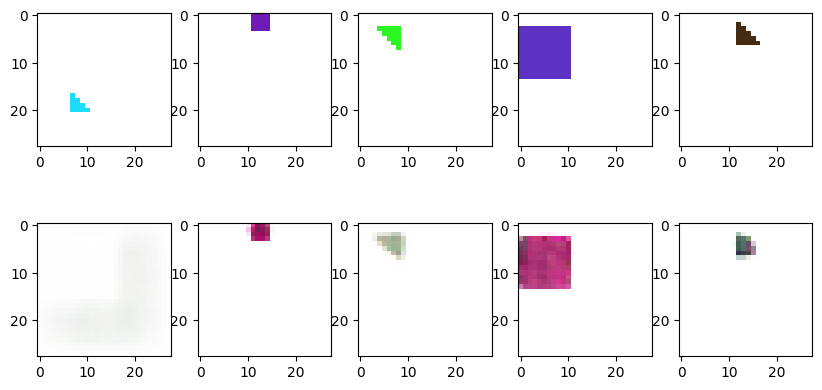

In [30]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)[0]
print(output.shape, random_batch.shape)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


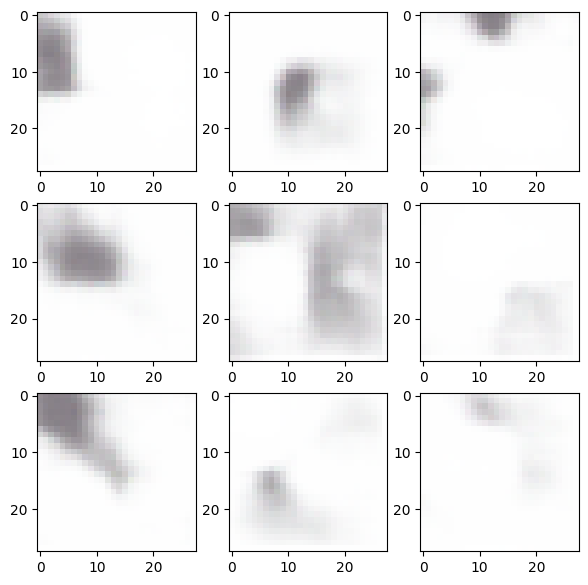

In [110]:
#sampling from the latent space
n = 9
z_dim = 32
mu = torch.zeros(n, z_dim).to(device)
logvar = torch.zeros(n, z_dim).to(device)
z = model.reparameterize(mu, logvar)
output = model.decode(z)


plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    #plt.title(f'z: {z.detach().cpu().numpy().round(2)}')
